
**Objective**: The task here is investigating how fake news can be identified and developing a method to detect it. To approach this problem, I’ll begin by exploring and cleaning the data, then move on to building a model to classify news stories as either fake or factual. I’ll also create visualizations to better understand the results and think about how to effectively communicate my findings to stakeholders.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import spacy
from spacy import displacy, tokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim.corpora as corpora
from gensim.models import LsiModel, LdaModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# set plot options
plt.rcParams['figure.figsize'] = (12, 10)
default_plot_colour = "#3d9acc"

## **Import Data**

In [ ]:
data = pd.read_csv('fake_news.csv')

In [ ]:
data.head(10)

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News


In [ ]:
data.isnull().sum()

,0
title,0
text,0
date,0
fake_or_factual,0


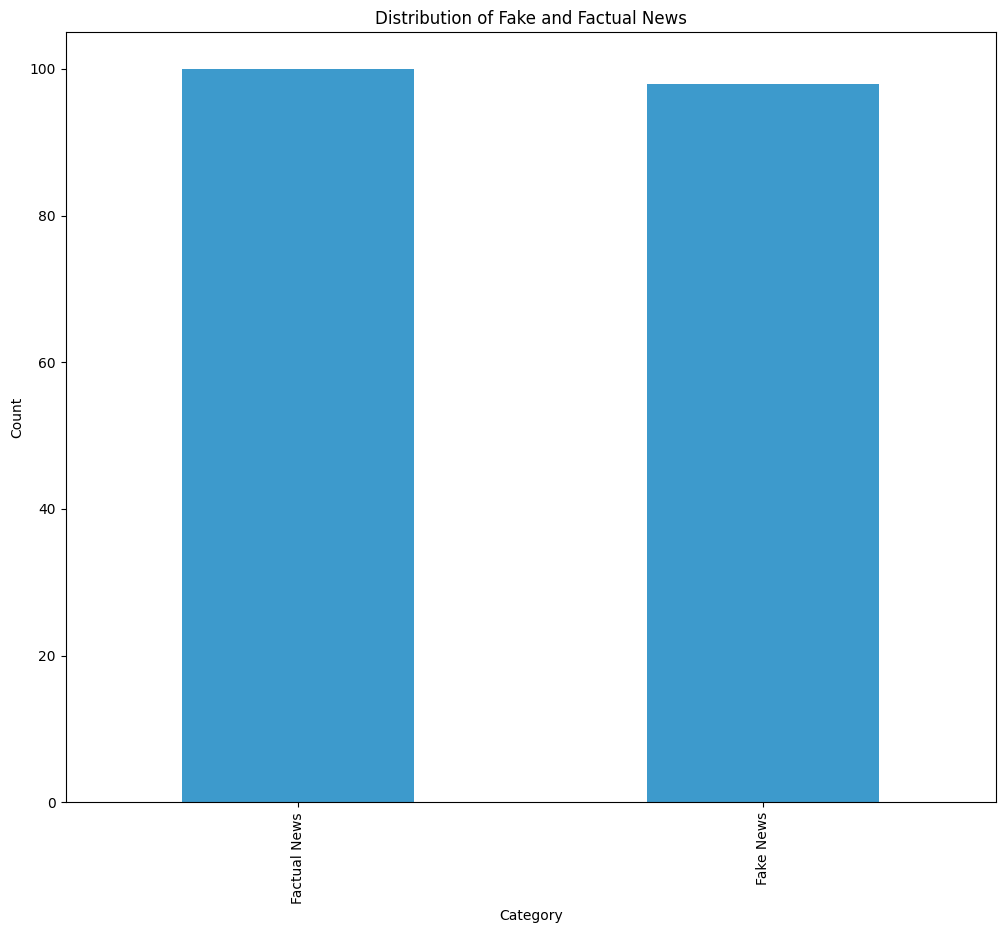

In [ ]:
data['fake_or_factual'].value_counts().plot(kind='bar',color=default_plot_colour)
plt.title('Distribution of Fake and Factual News')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

## Parts of Speech (POS) Tagging

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
 #seperating fake and factual news into seperate dataframes
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [ ]:
# create spacey documents - use pipe for dataframe
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(fact_news['text']))

In [ ]:
# create function to extract tags for each document in our data
# def get_token_tags(doc):
#   return [(token.text, token.ent_type_, token.pos_) for token in doc]

# create function to extract tags for each document in our data
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [ ]:
# tagging the fake dataset
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for doc in fake_spaceydocs:
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

fake_tagsdf = pd.concat(fake_tagsdf)

# tagging the factual dataset
fact_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for doc in fact_spaceydocs:
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [ ]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [ ]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [ ]:
# token frequency count (fake)
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [ ]:
# token frequency count (factual)
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [ ]:
# frequencies of pos tags
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2586
VERB,1817
PROPN,1672
ADJ,882
ADV,413
NUM,221
PRON,96
ADP,89
AUX,62


In [ ]:
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

,token
pos_tag,
NOUN,2179
VERB,1539
PROPN,1379
ADJ,747
ADV,263
NUM,205
PRON,79
ADP,70
AUX,43


In [ ]:
# top 15 nouns in the fake dataset
pos_counts_fake[pos_counts_fake['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
8011,year,NOUN,44
3138,campaign,NOUN,44
4581,government,NOUN,41
8013,years,NOUN,40
5213,law,NOUN,40


In [ ]:
# top 15 nouns in the factual dataset
pos_counts_fact[pos_counts_fact['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## **Named Entities**

In [ ]:
# top entities in fake news
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""].groupby(['token','ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [ ]:
# top entities in factual news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""].groupby(['token','ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

In [ ]:
# creating a standardized custom color palette to create consistent ner plots
ner_colors = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

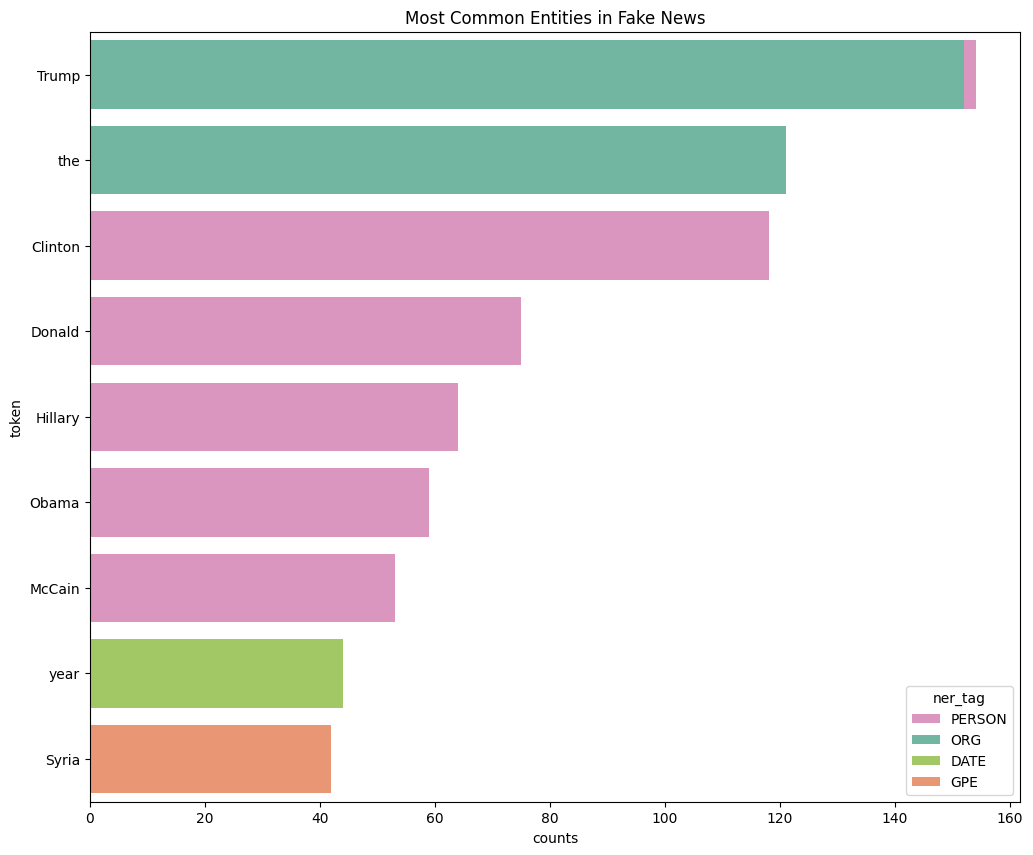

In [ ]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_colors,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

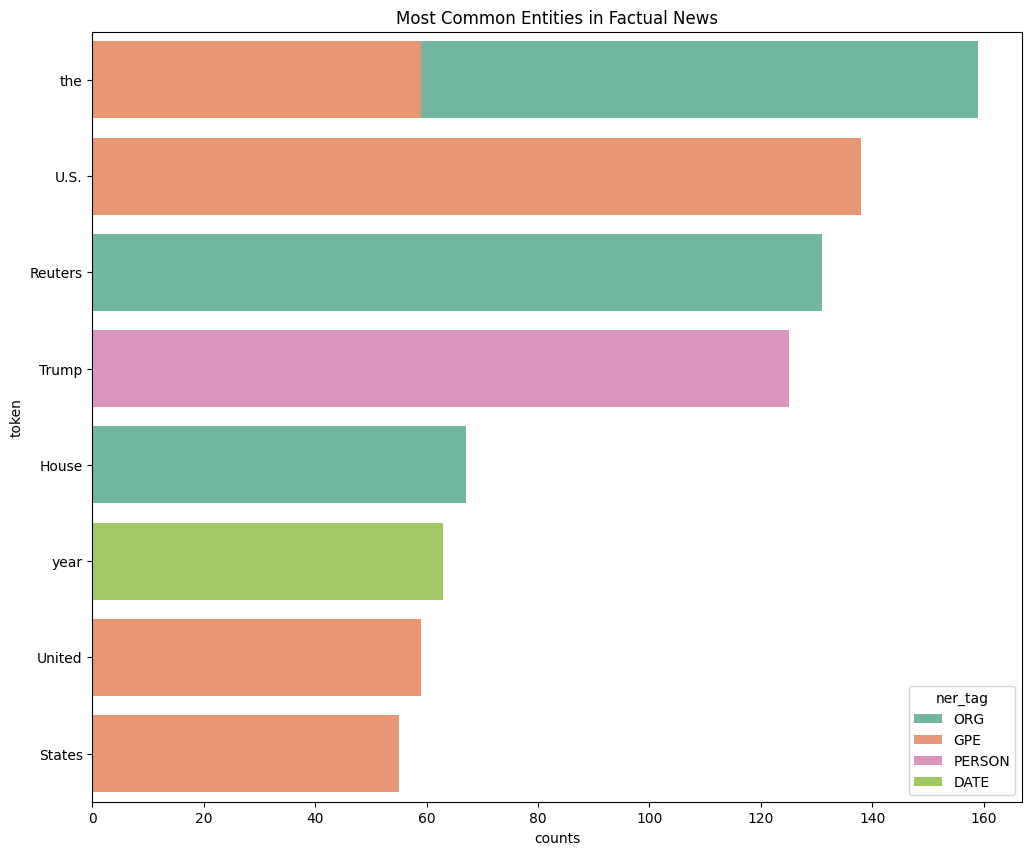

In [ ]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_colors,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
).set(title='Most Common Entities in Factual News')

## **Text Pre-processing**

In [ ]:
# a lot of the factual news has a location tag at the beginning of the article, using regex to remove this
# the regex expression removes everything from the beginning of each text entry up to and including the first hyphen and any spaces that follow it.
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

In [ ]:
# lowercasing the cleaned text
data['text_clean'] = data['text_clean'].str.lower()

In [ ]:
# remove punctuation from cleaned text
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [ ]:
# removing stop words
en_stopwords = stopwords.words('english')
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [ ]:
# tokenize the text_clean
data['text_clean'] =  data['text_clean'].apply(lambda x: word_tokenize(x))

In [ ]:
# lemmatize the text_clean column
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [ ]:
# finding the most common unigrams after preprocessing
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7  (republican,)    128
8        (year,)    128
9        (also,)    124


In [ ]:
# extract the token from the tuple
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])

<ipython-input-177-9b00e2f7d7f3>:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

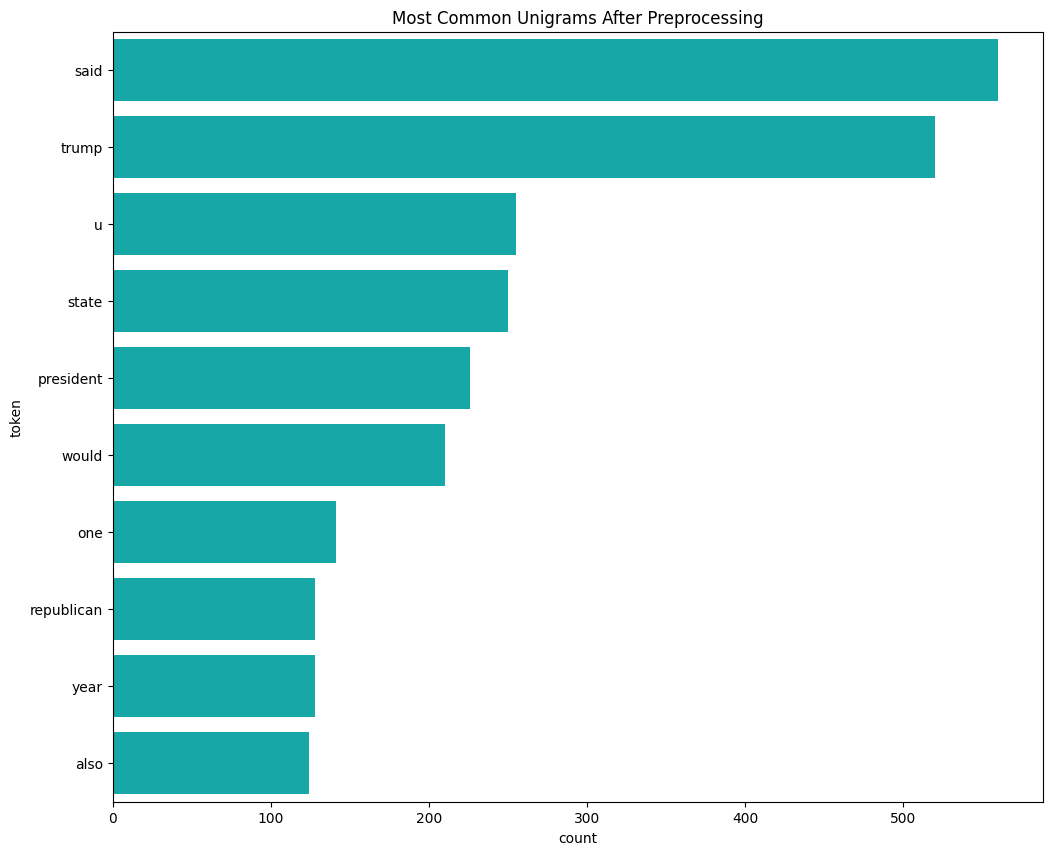

In [ ]:
sns.barplot(x = "count",
            y = "token",
            data=unigrams,
            orient = 'h',
            palette=['#00bfbf'],
            hue = "token", legend = False).set(title='Most Common Unigrams After Preprocessing')


In [ ]:
# finding the most common bigrams after preprocessing
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)     92
1          (united, state)     80
2           (white, house)     72
3      (president, donald)     42
4       (hillary, clinton)     31
5              (new, york)     31
6             (image, via)     29
7         (supreme, court)     29
8         (official, said)     26
9  (trump, administration)     24


## **Sentiment Analysis**

In [ ]:
# use vader in order to also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

In [ ]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [ ]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [ ]:
data.head(10)

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News,"[58, resolution, consider, move, week, fox, ne...",-0.6781,negative
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News,"[inneck, race, must, pretty, antsy, though, un...",0.9970,positive
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News,"[seattle, financial, worker, harrison, karlewi...",0.9937,positive
8,Stephen King Is BRUTALLY Making Fun Of Trump ...,With Donald Trump s intensely bizarre and craz...,"March 4, 2017",Fake News,"[donald, trump, intensely, bizarre, crazy, twe...",-0.9726,negative
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News,"[u, presidentelect, donald, trump, call, taiwa...",0.4951,positive


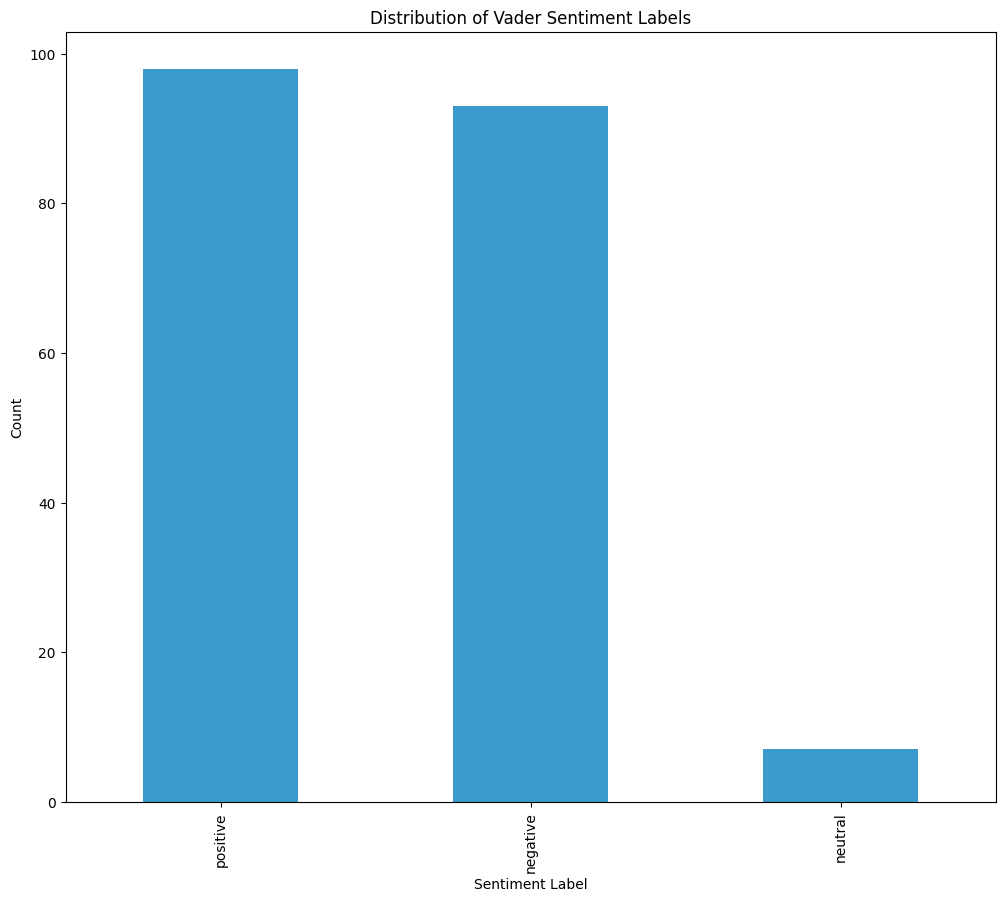

In [ ]:
data['vader_sentiment_label'].value_counts().plot(kind='bar',color=default_plot_colour)
plt.title('Distribution of Vader Sentiment Labels')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

[Text(0.5, 1.0, 'Sentiment Analaysis based on News Type')]

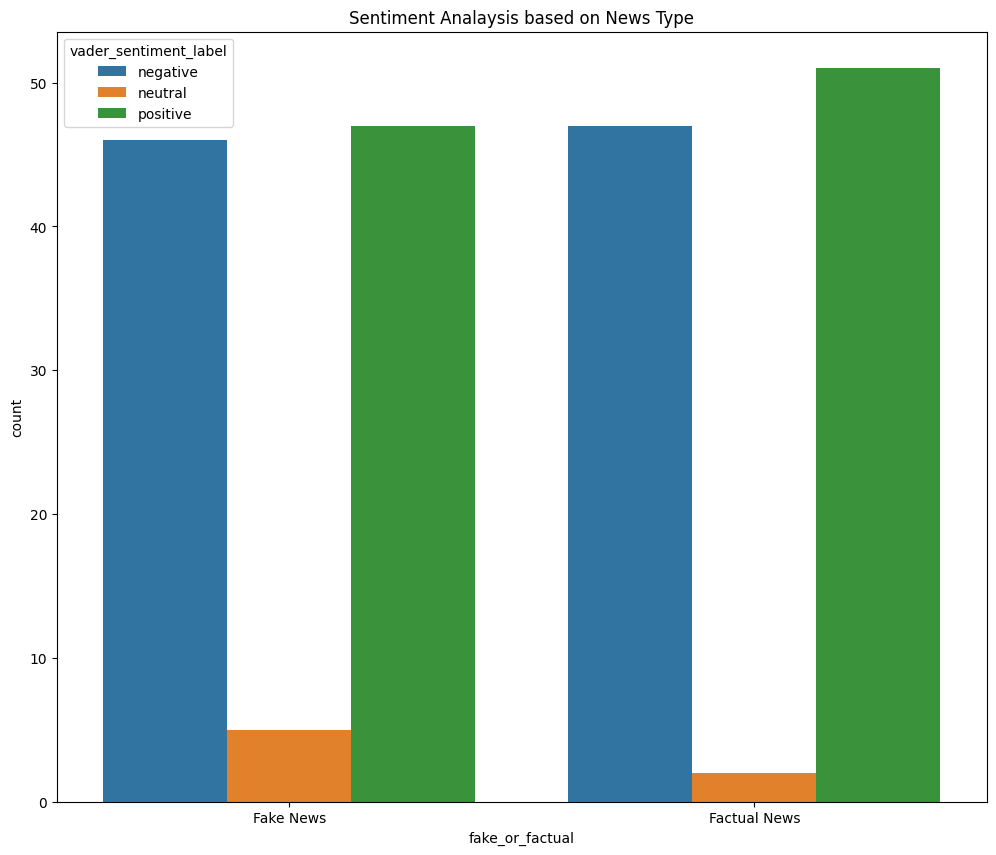

In [ ]:
# making a counplot to analyze the number of positive and negative sentiments across fake and factual news
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    data = data
).set(title='Sentiment Analaysis based on News Type')

 ## **Topic Modelling using LDA**

In [ ]:
# extracting text_clean for all the fake news articles
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)

In [ ]:
fake_news_text.head()

,text_clean
0,"[yearold, oscarwinning, actress, described, me..."
1,"[buried, trump, bonkers, interview, new, york,..."
2,"[woman, make, 50, percent, country, grossly, u..."
3,"[58, resolution, consider, move, week, fox, ne..."
4,"[inneck, race, must, pretty, antsy, though, un..."


In [ ]:
# create a dictionary of unique words in the dataset using corpora
dictionary_fake = corpora.Dictionary(fake_news_text)

In [ ]:
doc_term_fake = [dictionary_fake.doc2bow(doc) for doc in fake_news_text]

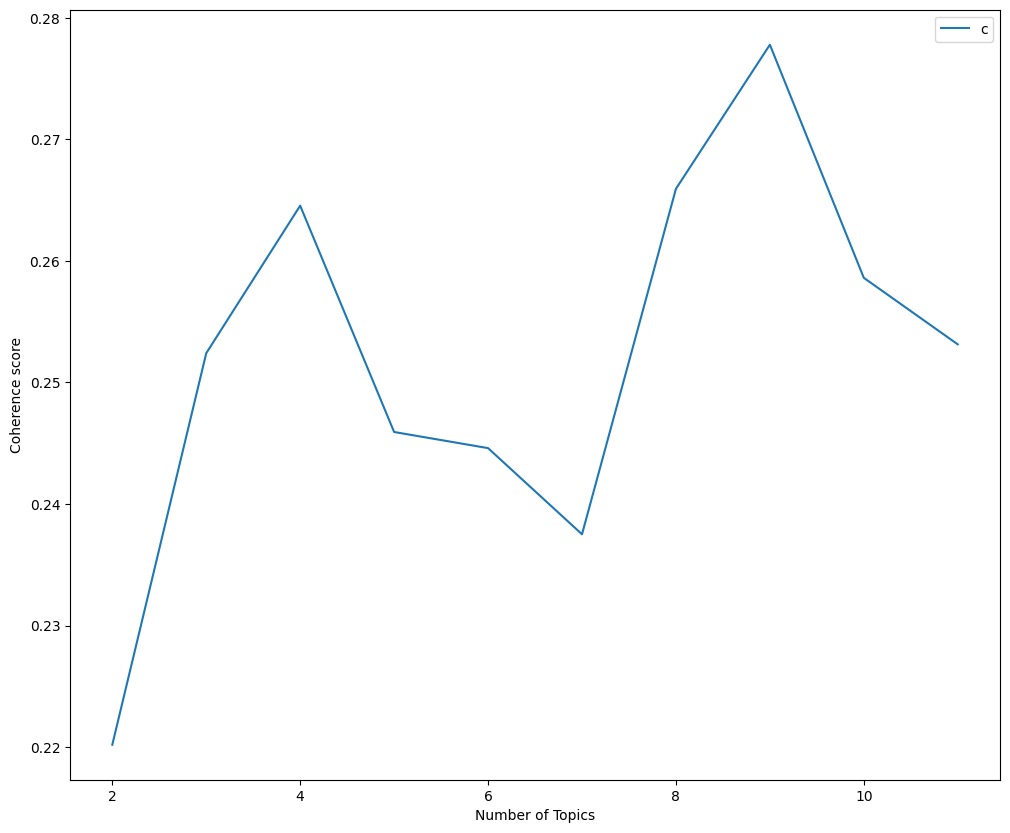

In [ ]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# create lda model, based on the graph we infer that number of topics should 7
num_topics_fake = 7

lda_model_fake = LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.005*"trump" + 0.004*"clinton" + 0.003*"said" + 0.003*"u" + 0.003*"president" + 0.003*"food" + 0.003*"one" + 0.003*"people" + 0.003*"million" + 0.002*"stamp"'),
 (1,
  '0.009*"trump" + 0.005*"clinton" + 0.004*"would" + 0.003*"flynn" + 0.003*"one" + 0.003*"said" + 0.003*"u" + 0.003*"hillary" + 0.003*"state" + 0.002*"time"'),
 (2,
  '0.015*"trump" + 0.005*"president" + 0.005*"time" + 0.005*"clinton" + 0.004*"said" + 0.004*"woman" + 0.004*"would" + 0.003*"one" + 0.003*"republican" + 0.003*"know"'),
 (3,
  '0.008*"trump" + 0.006*"one" + 0.004*"year" + 0.004*"obama" + 0.003*"u" + 0.003*"said" + 0.003*"state" + 0.003*"would" + 0.003*"time" + 0.003*"law"'),
 (4,
  '0.011*"trump" + 0.006*"republican" + 0.005*"said" + 0.005*"state" + 0.004*"party" + 0.003*"president" + 0.003*"u" + 0.003*"would" + 0.003*"people" + 0.003*"time"'),
 (5,
  '0.016*"trump" + 0.007*"said" + 0.005*"president" + 0.005*"state" + 0.004*"would" + 0.004*"clinton" + 0.004*"time" + 0.003*"email" + 0.003*"official" + 

In [ ]:
# Most topics found contain very similar words, so instead we will be using latent semantic anaysis with tf-idf vectorization

## **TF-IDF & Topic Modelling using LSA**

In [ ]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [ ]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

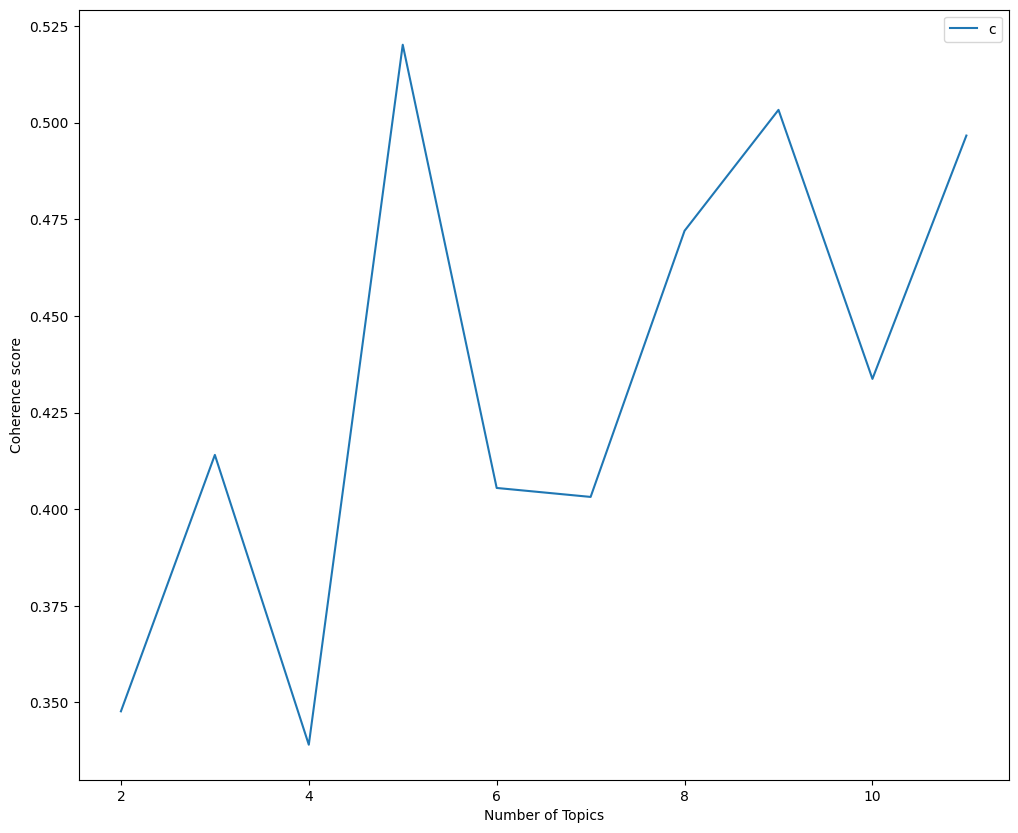

In [ ]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [ ]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics(num_topics=5, num_words=10)

[(0,
  '-0.218*"trump" + -0.135*"clinton" + -0.094*"woman" + -0.087*"president" + -0.086*"republican" + -0.085*"obama" + -0.084*"party" + -0.083*"school" + -0.081*"said" + -0.079*"time"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"savant" + 0.119*"moralist"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '-0.235*"trump" + -0.223*"flynn" + -0.166*"conference" + 0.165*"clinton" + 0.153*"dnc" + 0.151*"sander" + 0.127*"email" + -0.111*"press" + 0.109*"rich" + -0.084*"tax"')]

## **Creating our classifier model to predict fake or factual news**

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [ ]:
# Creating features to training and prediction by the AI
X = [','.join(map(str, x)) for x in data['text_clean']]
y = data['fake_or_factual']

In [ ]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [ ]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3)

In [ ]:
# creating a logistic regression model as a baseline classifier
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
# Making predictions on the test data
y_pred_lr = lr.predict(X_test)

In [ ]:
# Calculating accuracy of the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr}")

Accuracy: 0.9166666666666666


In [ ]:
# classification report for the logistic regression model
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.89      0.92      0.91        26
   Fake News       0.94      0.91      0.93        34

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [ ]:
# Creating a svm model to perform classification
svm = SGDClassifier().fit(X_train, y_train)

In [ ]:
# Making predictions on the test data
y_pred_svm = lr.predict(X_test)

In [ ]:
# Calculating accuracy of the logistic regression model
accuracy_svm = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_svm}")

Accuracy: 0.9166666666666666


In [ ]:
# classification report for the svm model
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.89      0.92      0.91        26
   Fake News       0.94      0.91      0.93        34

    accuracy                           0.92        60
   macro avg       0.91      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60

